In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ===========================
# 1. 加载 MNIST 数据
# ===========================
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="../assets", train=True, transform=transform, download=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [2]:
class MNISTMLP(nn.Module):
    def __init__(self, embed_dim=64, hidden_dim=256, img_size=28):
        super().__init__()
        self.embed_dim = embed_dim
        self.img_size = img_size

        # 文本输入（单个数字）Embedding
        self.token_embedding = nn.Embedding(10, embed_dim)

        # MLP 网络
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, img_size * img_size)
        self.activation = nn.ReLU()

    def forward(self, text_input):
        batch_size = text_input.shape[0]

        # 数字映射到嵌入向量
        text_embedded = self.token_embedding(text_input)  # (batch, embed_dim)

        # 通过 MLP 处理
        hidden = self.activation(self.fc1(text_embedded))  # (batch, hidden_dim)
        output_image = self.fc2(hidden)  # (batch, 28*28)

        # 变成 28x28 图片
        output_image = output_image.view(batch_size, self.img_size, self.img_size)

        return output_image  # (batch, 28, 28)



In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

num_epochs = 5

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.size(0), -1)  # Flatten 28x28 -> 784 pixels

        optimizer.zero_grad()
        output = model(labels)  # 输入文本数字，生成图像
        loss = loss_fn(output.view(output.size(0), -1), images)  # 计算 MSE 损失
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}")

Epoch [1/5], Batch [0], Loss: 0.1623
Epoch [1/5], Batch [200], Loss: 0.0567
Epoch [1/5], Batch [400], Loss: 0.0549
Epoch [1/5], Batch [600], Loss: 0.0536
Epoch [1/5], Batch [800], Loss: 0.0530
Epoch [2/5], Batch [0], Loss: 0.0529
Epoch [2/5], Batch [200], Loss: 0.0506
Epoch [2/5], Batch [400], Loss: 0.0561
Epoch [2/5], Batch [600], Loss: 0.0539
Epoch [2/5], Batch [800], Loss: 0.0527
Epoch [3/5], Batch [0], Loss: 0.0524
Epoch [3/5], Batch [200], Loss: 0.0610
Epoch [3/5], Batch [400], Loss: 0.0537
Epoch [3/5], Batch [600], Loss: 0.0555
Epoch [3/5], Batch [800], Loss: 0.0559
Epoch [4/5], Batch [0], Loss: 0.0528
Epoch [4/5], Batch [200], Loss: 0.0523
Epoch [4/5], Batch [400], Loss: 0.0537
Epoch [4/5], Batch [600], Loss: 0.0561
Epoch [4/5], Batch [800], Loss: 0.0562
Epoch [5/5], Batch [0], Loss: 0.0550
Epoch [5/5], Batch [200], Loss: 0.0605
Epoch [5/5], Batch [400], Loss: 0.0563
Epoch [5/5], Batch [600], Loss: 0.0503
Epoch [5/5], Batch [800], Loss: 0.0537


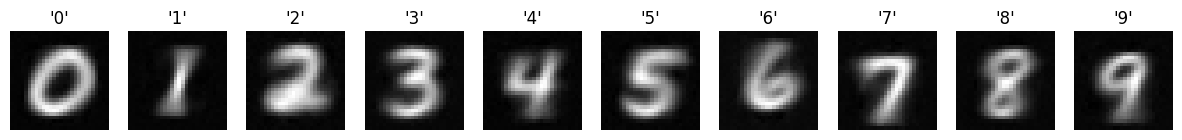

In [4]:
# 4. 生成 0-9 的手写数字，并排显示
# ===========================
model.eval()
text_inputs = torch.tensor([i for i in range(10)]).to(device)  # 生成 0-9 对应的手写图像
generated_images = model(text_inputs).detach().cpu().numpy()

# 显示 0-9 生成的手写图像
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap="gray")
    ax.set_title(f"'{i}'")
    ax.axis("off")

plt.show()

In [5]:
torch.save({
    'epoch': epoch,  # 记录当前训练到第几轮
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "baselinecheckpoint.pth")